# 0 Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Colab/Project/QC/'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import sqrt, floor
import torch
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn import mixture
import os
import pandas as pd
from skimage.feature import blob_dog
import csv

# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline

from skimage.metrics import peak_signal_noise_ratio
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0


# 3 Dataset

### 3.1 Display RGB, Mask and Mask Overlayed on Original Image

In [ ]:
def overlay_image(img, csv_file):
    img_overlay = img.copy()
    with open(csv_file) as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # skip header
        for row in reader:
            coords_x = list(map(int, row[9].split(',')))
            coords_y = list(map(int, row[10].split(',')))
            pts = np.array(list(zip(coords_x, coords_y)))
            cv2.polylines(img_overlay, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

    return img_overlay

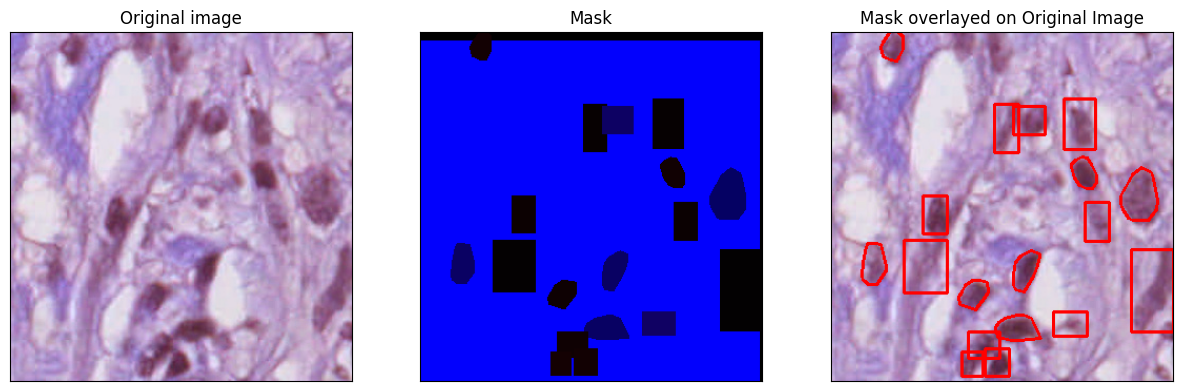

In [ ]:
# define the paths for the input image and corresponding mask
data = 'TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-7053_top-53967_bottom-54231_right-7311'
image_path = path + 'rgb/' + data + '.png'
mask_path = path + 'mask/' + data + '.png'
csv_path = path + 'csv/' + data + '.csv'

# read the input image and mask
image = cv2.imread(image_path)
mask = cv2.imread(mask_path)
csv_file = os.path.join(csv_path)

img1_overlay = overlay_image(image, csv_file)

# Create a subplot with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

# Display the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original image")
ax[0].set_xticks([])
ax[0].set_yticks([])

# Display the mask in the second column
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].set_xticks([])
ax[1].set_yticks([])

# Display the original image with contours around each nucleus in the third column
ax[2].imshow(img1_overlay)
ax[2].set_title("Mask overlayed on Original Image")
ax[2].set_xticks([])
ax[2].set_yticks([])

# Display the plot
plt.show()



### 3.2 Training and Validation Split

In [ ]:
import os
import random

# Initialize set of patient IDs (to prevent duplicates)
patient_ids = set()

# Loop over all the files in the RGB folder
for file in os.listdir(os.path.join(path, 'rgb')):
    if file.endswith('.png'):
        # Extract the patient ID from the file name
        patient_id = file.split('_id-')[0]

        # Add the patient ID to the set
        patient_ids.add(patient_id)

# Convert patient IDs set to a list
patient_ids = list(patient_ids)

# Shuffle patient IDs
random.shuffle(patient_ids)

# Calculate number of patients in each set
num_train = int(len(patient_ids) * 0.8)
num_valid = len(patient_ids) - num_train

# Split patient IDs into training and validation sets
train_ids = patient_ids[:num_train]
valid_ids = patient_ids[num_train:]

print("training data: {:.1f}%".format(len(train_ids) * 100 / len(patient_ids)))
print("validation data: {:.1f}%".format(len(valid_ids) * 100 / len(patient_ids)))

# Create splits directory if it doesn't exist
splits_dir = os.path.join(path, "splits")
if not os.path.exists(splits_dir):
    os.mkdir(splits_dir)

# Save training and validation sets as CSV files in splits directory
train_file = os.path.join(splits_dir, "train_subjects.csv")
with open(train_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['patient_id'])
    for id in train_ids:
        writer.writerow([id])

valid_file = os.path.join(splits_dir, "validate_subjects.csv")
with open(valid_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['patient_id'])
    for id in valid_ids:
        writer.writerow([id])

training data: 79.8%
validation data: 20.2%


# 4 Segmentation

## 4.1 Segmentation - Unsupervised

### K-means clustering implementation

In [ ]:
# https://stackoverflow.com/questions/60916020/numpy-linalg-norm-vs-scipy-cdist-for-l2-norm
# compute distance between each pair of the two collections of inputs.
def cdist(a, b):
  return np.linalg.norm(a[:, None, :] - b[None, :,  :], axis=2)

# get assignments of points based on closest centroid
def getAssignment(X, centroids):
  # find dists between X and centroids
  dists = cdist(X, centroids)

  # assign each point in X to the closest centroid
  assignment = np.array([np.argmin(i) for i in dists])

  return assignment

def updateCentriods(x, k, assignments):
  centroids = []
  for i in range(k):
      centroid = x[assignments == i].mean(axis=0) 
      centroids.append(centroid)

  return np.vstack(centroids)

def segmentImage(assignments, centroids):
  rows = assignments.shape[0]
  cols = assignments.shape[1]
  ndims = centroids.shape[1]

  # set image shape based on ndims
  if (ndims == 1):
    img_shape = (rows, cols)
  else:
    img_shape = (rows, cols, ndims)

  image = np.zeros(img_shape, dtype=np.uint8)
  for row in range(rows):
    for col in range(cols):
      image[row, col] = centroids[assignments[row, col]]
  
  return image

def plotImage(img, iteration, plots, i, grayscale=False):
  plt.subplot(1, plots, i)
  plt.xticks([]), plt.yticks([])

  if grayscale:
    plt.imshow(img, cmap="gray")
  else:
    plt.imshow(img)

  plt.title(f"Iteration: {iteration}")

# https://www.askpython.com/python/examples/k-means-clustering-from-scratch
# kmeans alg where x is list of datapoints, k is number of clusters
def kmeans(img, k, iterations, ndim=3, show=[]):
  # resize points 
  x = img.reshape(-1, ndim)

  # select k random points from x to init centroids
  idx = np.random.choice(len(x), k, replace=False)
  centroids = x[idx, :]
    
  # assign points to closest centroid
  assignments = getAssignment(x, centroids)
  
  # show the first assignemnt if 0 is in show 
  show_count = 0
  if 0 in show:
    show_count = show_count + 1
    img = segmentImage(assignments.reshape(img.shape[0], img.shape[1]), centroids)
    plotImage(img, 0, len(show), show_count, grayscale=(ndim == 1))
    
  # Repeating the above steps for a defined number of iterations
  for i in range(iterations): 
      # update centroids 
      centroids = updateCentriods(x, k, assignments)
      # assign points to centroid
      assignments = getAssignment(x, centroids)

      # show the resulting image if iteration is in the show array
      if (i + 1) in show:
        show_count = show_count + 1
        img = segmentImage(assignments.reshape(img.shape[0], img.shape[1]), centroids)
        plotImage(img, i+1, len(show), show_count, grayscale=(ndim == 1))


  # compute segmented image
  img = segmentImage(assignments.reshape(img.shape[0], img.shape[1]), centroids)

  return img

### Mask prediction and DICE coefficients implementation

In [ ]:
def calc_mask(img1, out):  
  # Convert segmented image to grayscale
  if len(img1.shape) == 3:
    g_disp = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY)
  else:
    g_disp = out

  # Create a mask from only the darkest points (tumor)
  mask_rough = g_disp == np.min(g_disp)

  # Find contours of segmented tumors
  contours, _ = cv2.findContours(mask_rough * g_disp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Fill contours of segmented tumors on the mask
  mask = np.zeros_like(g_disp)
  for contour in contours:
    area = cv2.contourArea(contour)
    if len(contour) >= 5:  # Minimum number of points required for contour drawing
      if area >= 110:
        cv2.drawContours(mask, [contour], 0, (255, 255, 255), -1)

  return mask, contours


In [ ]:
def cmpt_dice(img1,img2):
  img2 = np.resize(img2, img1.shape)
  
  img1_mask = cv2.threshold(img1, 60, 255, cv2.THRESH_BINARY)[1]
  img2_mask = cv2.threshold(img2, 60, 255, cv2.THRESH_BINARY_INV)[1]

  # Compute the intersection and union of the two masks
  intersection = np.logical_and(img1_mask, img2_mask)
  union = np.logical_or(img1_mask, img2_mask)
  
  # Compute the Dice coefficient
  dice = (2. * intersection.sum()) / (union.sum() + intersection.sum())

  return dice

### Load sample image and mask

In [ ]:
# define the paths for the input image and corresponding csv and mask
data = 'TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-7053_top-53967_bottom-54231_right-7311'
image_path = path + 'rgb/' + data + '.png'
csv_path = path + 'csv/' + data + '.csv'
mask_path = path + 'mask/' + data + '.png'

rgb_img = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
mask_img = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY)

### 4.1.1

In [ ]:
Ks = [2, 3, 4, 5, 6, 7, 8]
seg_results = []
mask_results = []
dices = []

for K in Ks:
  iterations = 10
  show = []
  res = kmeans(rgb_img, K, iterations, show=show)
  seg_results.append(res)
  prediction = calc_mask(rgb_img, res)[0]
  mask_results.append(prediction)
  dice = cmpt_dice(mask_img, prediction)
  dices.append(dice)

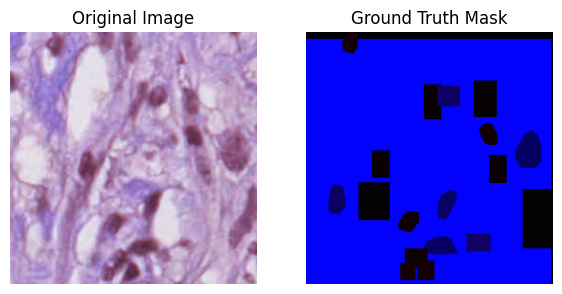

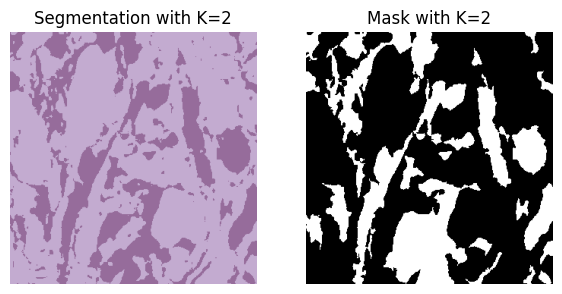

K=2 DICE: 0.4069682672431477


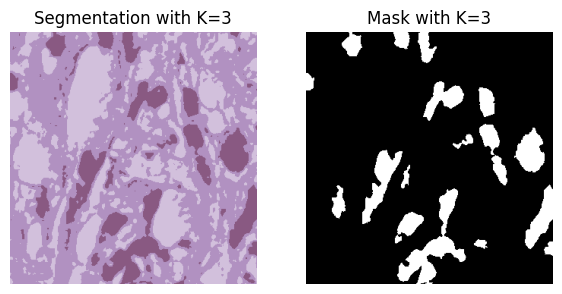

K=3 DICE: 0.4306796220742968


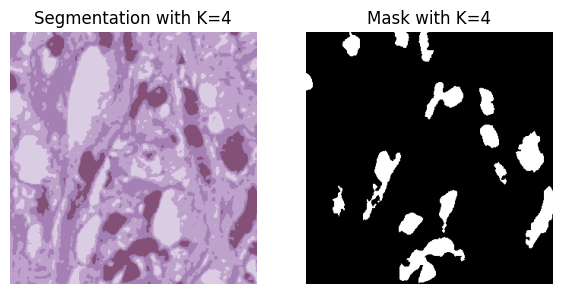

K=4 DICE: 0.4336970540453574


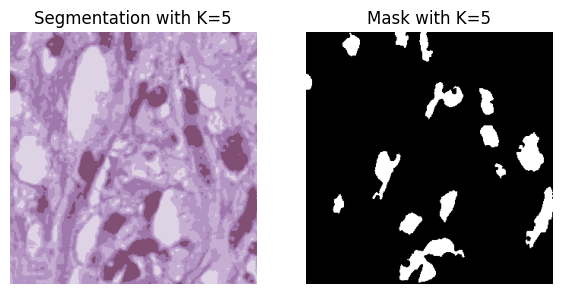

K=5 DICE: 0.43491326250892204


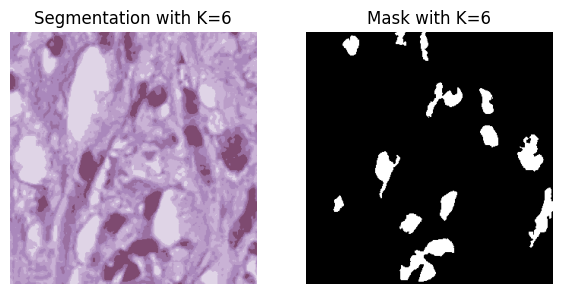

K=6 DICE: 0.43645228401128283


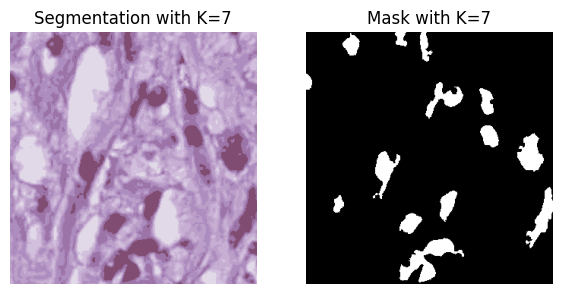

K=7 DICE: 0.4355620254727269


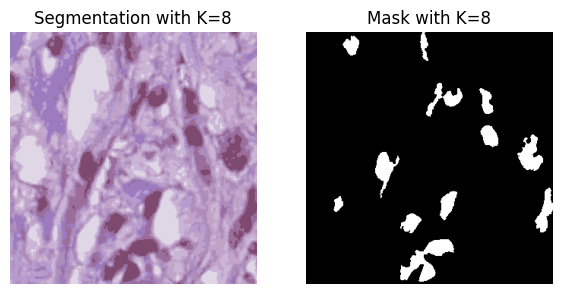

K=8 DICE: 0.43712099500620105


In [ ]:
plt.figure(figsize=(7,7))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_img, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')
plt.show()
  
for i in range(len(Ks)):
  plt.figure(figsize=(7,7))
  plt.subplot(1, 2, 1)
  plt.imshow(seg_results[i])
  plt.title(f'Segmentation with K={Ks[i]}')
  plt.axis('off')
  
  plt.subplot(1, 2, 2)
  plt.imshow(mask_results[i], cmap='gray')
  plt.title('Mask with K={}'.format(Ks[i]))
  plt.axis('off')

  plt.show()

  print("K={} DICE: {}".format(Ks[i],dices[i]))

Results for K=3 and K=5 are shown above (among others).

### 4.1.2

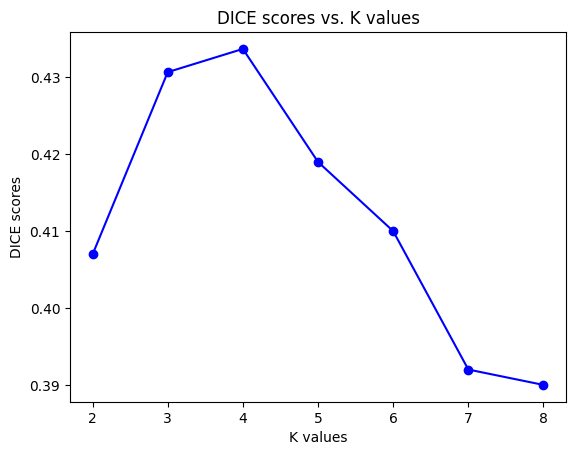

In [ ]:
plt.plot(Ks, ds, 'bo-')
plt.xlabel('K values')
plt.ylabel('DICE scores')
plt.title('DICE scores vs. K values')
plt.show()

Based on the DICE values, it is clear that the optimized K value is K=4.

### 4.1.3 Display original/segmented/ground truth images

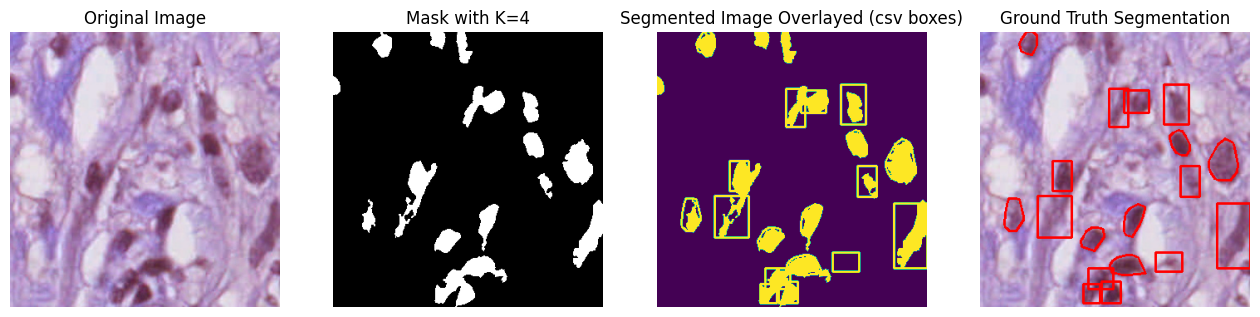

In [ ]:
K = 4

iterations = 10
show = []
res = kmeans(rgb_img, K, iterations, show=show)
prediction, shapes = calc_mask(rgb_img, res)

csv_file = os.path.join(csv_path)
prediction_overlay = overlay_image(prediction, csv_file)
img1_overlay = overlay_image(rgb_img, csv_file)

# Display original image
plt.figure(figsize=(16,10))
plt.subplot(1, 4, 1)
plt.imshow(rgb_img)
plt.title('Original Image')
plt.axis('off')

# Display segmented image for optimized K
plt.subplot(1, 4, 2)
plt.imshow(prediction, cmap='gray')
plt.title('Mask with K={}'.format(K))
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(prediction_overlay)
plt.title('Segmented Image Overlayed (csv boxes)'.format(K))
plt.axis('off')

# Display ground truth segmentation
plt.subplot(1, 4, 4)
plt.imshow(img1_overlay)
plt.title('Ground Truth Segmentation')
plt.axis('off')
plt.show()

On the third image "Segmented Image Overlayed (csv boxes)", we can see that the segmentation with K=5 retains most of the nuclei that are detected by the the csv boxes.

### 4.1.4 Repeat with Grayscale images

In [ ]:
# Convert rgb image to grayscale
gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

Ks = [2, 3, 4, 5, 6, 7, 8]
seg_results_gray = []
mask_results_gray = []
dices_gray = []


for K in Ks:
  iterations = 10
  show = []
  res = kmeans(gray, K, iterations, ndim=1, show=show)
  seg_results_gray.append(res)
  prediction = calc_mask(gray, res)[0]
  mask_results_gray.append(prediction)
  dice = cmpt_dice(mask_img, prediction)
  dices_gray.append(dice)

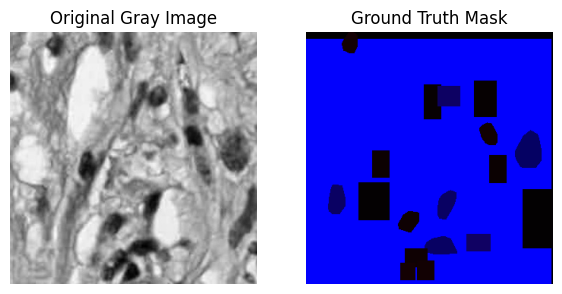

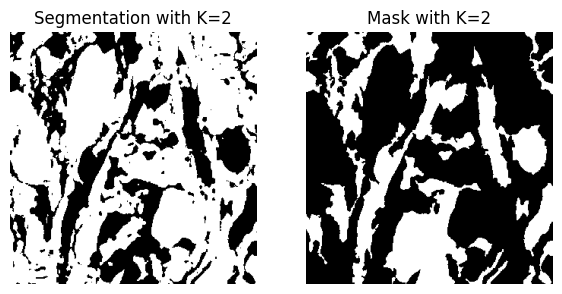

K=2 DICE: 0.4017888773689462


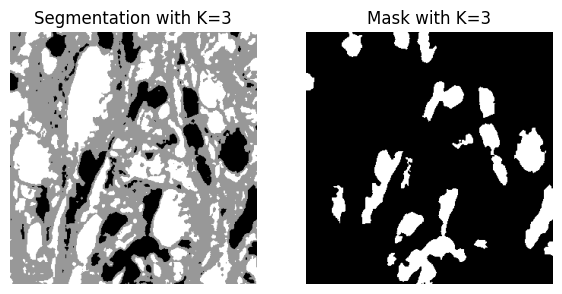

K=3 DICE: 0.42996630180524115


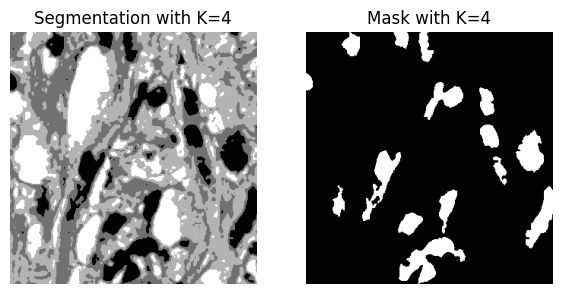

K=4 DICE: 0.433211024114265


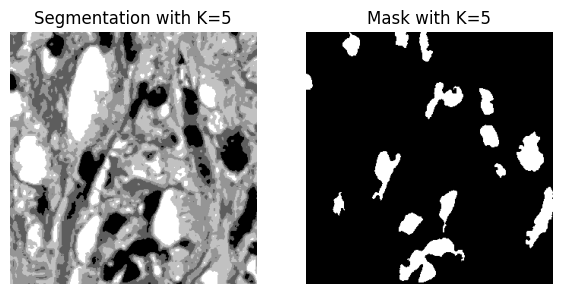

K=5 DICE: 0.4345654552904139


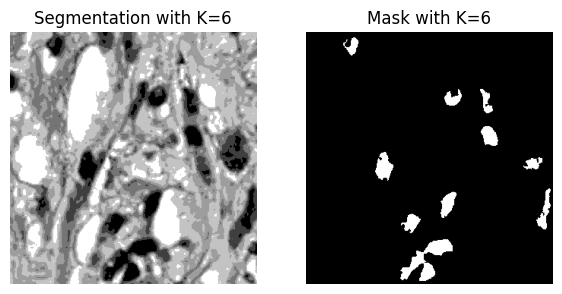

K=6 DICE: 0.43924620242150014


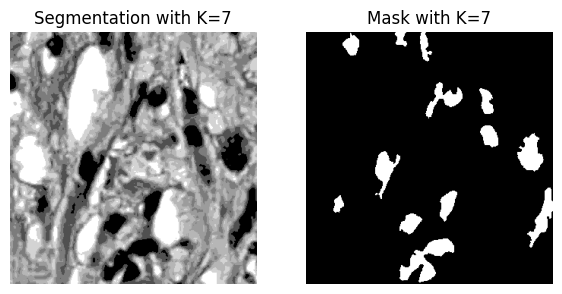

K=7 DICE: 0.43613732696469504


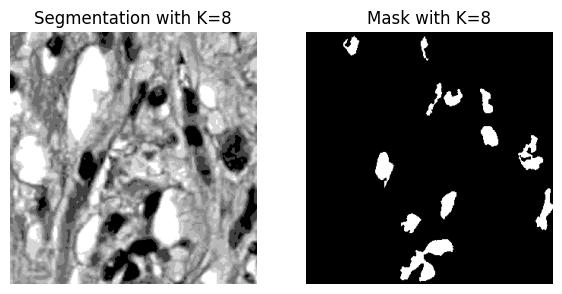

K=8 DICE: 0.4381870374230556


In [ ]:
plt.figure(figsize=(7,7))
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original Gray Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_img, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')
plt.show()
  
for i in range(len(Ks)):
  plt.figure(figsize=(7,7))
  plt.subplot(1, 2, 1)
  plt.imshow(seg_results_gray[i], cmap='gray')
  plt.title(f'Segmentation with K={Ks[i]}')
  plt.axis('off')
  
  plt.subplot(1, 2, 2)
  plt.imshow(mask_results_gray[i], cmap='gray')
  plt.title('Mask with K={}'.format(Ks[i]))
  plt.axis('off')

  plt.show()

  print("K={} DICE: {}".format(Ks[i],dices_gray[i]))

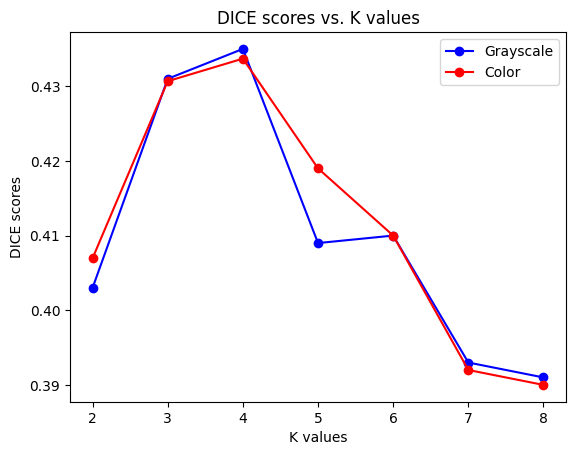

In [ ]:
plt.plot(Ks, ds_gray, 'bo-', label='Grayscale')
plt.plot(Ks, ds, 'ro-', label='Color')
plt.xlabel('K values')
plt.ylabel('DICE scores')
plt.title('DICE scores vs. K values')
plt.legend()
plt.show()

Segmentation on Grayscale images and RGB images give very similar results. In general, RGB segmentation seems to give better results. However, the best result overall is for K=4 on grayscale images.

### 4.1.5 Other Unsupervised method

Gaussian Mixture Models (GMMs) are a popular technique for unsupervised image segmentation because they can model complex distributions of image data and identify distinct regions in an image based on their statistical properties. By fitting a GMM to the image data, it is possible to cluster similar pixels into separate regions, allowing for the segmentation of objects and features within the image. Additionally, GMMs can be used to model the noise in an image, leading to more accurate segmentation results. Overall, GMMs are a powerful tool for unsupervised image segmentation due to their ability to capture complex image distributions and identify meaningful image features.

#### GMM Segmentation (optimize n_components param)

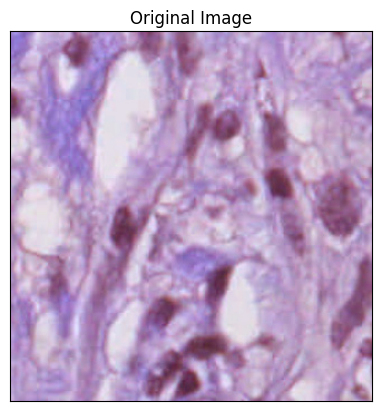

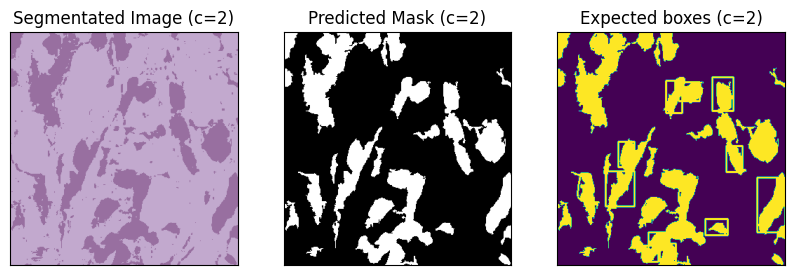

0.41635418644389594


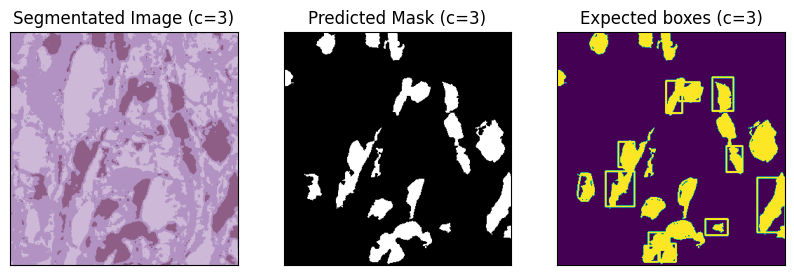

0.43050079871774877


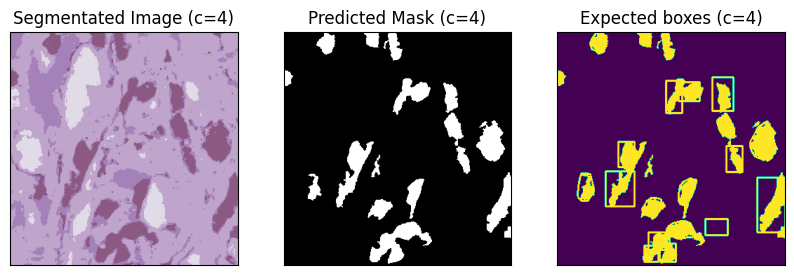

0.4319389207379524


In [ ]:
# Read an image
img = rgb_img.copy()

components = [2, 3, 4]

# Display Original Image
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.show()

for component in components:
  # Arrange img to a feature matrix and convert it to np.float32
  Z = img.reshape((-1,3))
  Z = np.float32(Z)

  # fit GMM on Z
  clf = mixture.GaussianMixture(n_components=component, covariance_type='full')
  clf.fit(Z)

  # predict cluster membership from the fitted GMM 
  label = clf.predict(Z)

  # create a segmentation image
  center = np.uint8(clf.means_)
  out = center[label.flatten()]
  out = out.reshape((img.shape))
  # Get mask prediction and compute DICE
  prediction = calc_mask(rgb_img, out)[0]
  dice = cmpt_dice(mask_img, prediction)
  # Overlay csv boxes
  csv_file = os.path.join(csv_path)
  prediction_overlay = overlay_image(prediction, csv_file)

  fig, ax = plt.subplots(1, 3, figsize=(10, 5))
  ax[0].imshow(out)
  ax[0].set_title("Segmentated Image (c={})".format(component))
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[1].imshow(prediction, cmap='gray')
  ax[1].set_title("Predicted Mask (c={})".format(component))
  ax[1].set_xticks([])
  ax[1].set_yticks([])
  ax[2].imshow(prediction_overlay)
  ax[2].set_title("Expected boxes (c={})".format(component))
  ax[2].set_xticks([])
  ax[2].set_yticks([])
  plt.show()

  print(dice)

The best component value is c=3. In terms of DICE coefficients, c=4 and c=3 are very similar. However, visualy, we can observe that c=3 is slightly better

#### Best GMM Segmentation vs Best KMeans Segmentation

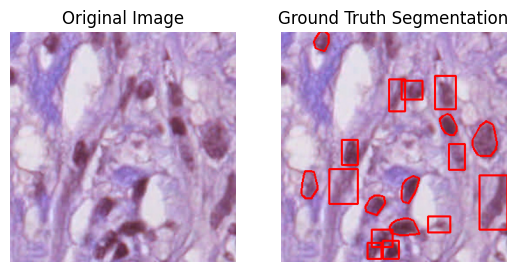

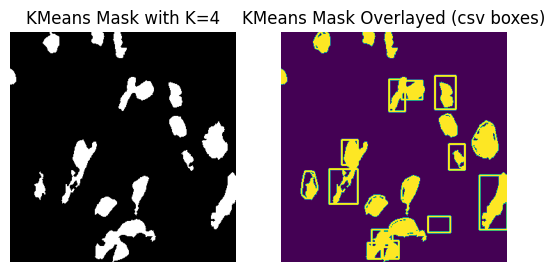

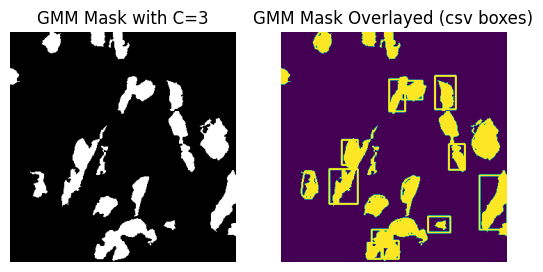

KMeans K=4  DICE: 0.4335649318168128
GMM    C=3  DICE: 0.43050079871774877


In [ ]:
# Display original image
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title('Original Image')
plt.axis('off')
# Display ground truth segmentation
plt.subplot(1, 2, 2)
plt.imshow(img1_overlay)
plt.title('Ground Truth Segmentation')
plt.axis('off')
plt.show()



# Compute best KMeans
K = 4
iterations = 10
show = []
res = kmeans(rgb_img, K, iterations, show=show)
prediction, shapes = calc_mask(rgb_img, res)
csv_file = os.path.join(csv_path)
prediction_overlay = overlay_image(prediction, csv_file)
img1_overlay = overlay_image(rgb_img, csv_file)
dice_kmeans = cmpt_dice(mask_img, prediction)


# Display segmented image for optimized K
plt.subplot(1, 2, 1)
plt.imshow(prediction, cmap='gray')
plt.title('KMeans Mask with K={}'.format(K))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(prediction_overlay)
plt.title('KMeans Mask Overlayed (csv boxes)')
plt.axis('off')
plt.show()



# Compute best GMM
C = 3
Z = img.reshape((-1,3))
Z = np.float32(Z)
# fit GMM on Z
clf = mixture.GaussianMixture(n_components=C, covariance_type='full')
clf.fit(Z)
# predict cluster membership from the fitted GMM 
label = clf.predict(Z)
# create a segmentation image
center = np.uint8(clf.means_)
out = center[label.flatten()]
out = out.reshape((img.shape))
# Get mask prediction and compute DICE
prediction = calc_mask(rgb_img, out)[0]
dice_gmm = cmpt_dice(mask_img, prediction)
# Overlay csv boxes
csv_file = os.path.join(csv_path)
prediction_overlay = overlay_image(prediction, csv_file)

# Display segmented mask for optimized C (GMM)
plt.subplot(1, 2, 1)
plt.imshow(prediction, cmap='gray')
plt.title('GMM Mask with C={}'.format(C))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction_overlay)
plt.title('GMM Mask Overlayed (csv boxes)')
plt.axis('off')
plt.show()

print('KMeans K={}  DICE: {}'.format(K, dice_kmeans))
print('GMM    C={}  DICE: {}'.format(C, dice_gmm))

KMeans DICE is slightly better than GMM DICE, and visualy the KMeans segmentation is better than GMM segmentation.

## 4.2 Segmentation - Supervised

### Helpers

In [ ]:
rgb_f = 'rgb/'
csv_f = 'csv/'
mask_f = 'mask/'

def get_patient_ids(train=True):
  ids = []
  if train == True:
    csv_path = path + 'splits/train_subjects.csv'
  else:
    csv_path = path + 'splits/validate_subjects.csv'

  with open(csv_path) as csvfile:
    reader = csv.reader(csvfile)   
    next(reader)  # skip header row

    # read each ID from the CSV file
    for row in reader:
        id = row[0]
        ids.append(id)

  return ids

def get_all_image_names_for_id(id):
  images = []
  for file in os.listdir(os.path.join(path, 'rgb')):
    if file.endswith('.png'):
      # Extract the patient ID from the file name
      filename = file.split(".png")[0]
      if id in filename:
        images.append(filename)
  return images

def get_rgb(file_name):
  #load image
  file_path = os.path.join(path+rgb_f, file_name+'.png')
  img = cv2.imread(file_path)
  return img

def get_mask(file_name):
  #load image
  file_path = os.path.join(path+mask_f, file_name+'.png')
  img = cv2.imread(file_path)  
  return img

def get_csv(file_name):
  #load csv
  file_path = os.path.join(path+csv_f, file_name+'.csv')
  return file_path

In [ ]:
def label_array(img, csv_path):
  labels = []
  #Create mask
  mask = np.zeros_like(img)
  with open(csv_path) as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      next(reader) #skip header
      for r in reader:
        coords_x = r[9] #in string format
        coords_x = [int(x) for x in coords_x.split(',')] #converting to int
        coords_y = r[10] #in string format
        coords_y = [int(x) for x in coords_y.split(',')] #converting to int

        pts = []
        for i in range(len(coords_x)):
          pts.append([coords_x[i], coords_y[i]])
        pts = np.array(pts)
        # Fill the polygon with black color
        cv2.fillPoly(mask, [pts], (255, 255, 255))

  # Determine if a pixel is inside or outside of the polygon
  for pixel in mask.ravel():
    if pixel > 0:
        labels.append(1) #Pixel is inside the polygon
    else:
        labels.append(0) #Pixel is outside the polygon

  return labels

### 4.2.1

The supervised approach we are using is a Random Forest Classifier, which involves training a model on a labeled dataset to predict class labels for the new data. We chose this approach because it is effective in handling complex datasets with high-dimensional feature spaces, and it can provide good accuracy and robustness in segmentation tasks. The Random Forest algorithm is also able to handle noisy and missing data, and it can give insight into the relative importance of different features in the classification process.

### 4.2.2

#### Train the classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import itertools

In [ ]:
# Get train and validation ids
train_ids = get_patient_ids(True)

X = []
y = []
# Get images for each id
for id in train_ids:
  train_paths = get_all_image_names_for_id(id)
  for train_path in train_paths[:2]:
    img1 = get_rgb(train_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    csv1 = get_csv(train_path)
    labels1 = label_array(img1, csv1)
    X.append(img1.ravel())
    y.append(labels1)

X = [int(x) for x in itertools.chain(*X)]
y = [int(x) for x in itertools.chain(*y)]
#Train random forest classifer on 100 image
X = np.array(X).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)
# Train the random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [ ]:
from joblib import dump
#Save the model to disk
dump(clf, path+'198.joblib')

In [ ]:
from joblib import load
# Load the model from disk
clf = load(path+'198.joblib')

In [ ]:
np.save(path+'X_train_198.npy',X)
np.save(path+'y_train_198.npy',y)

#### Helpers

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def test_classifier_plot(clf, X_test, y_test, img_test):
  y_pred = clf.predict(X_test)

  #plotting mask from predicted label
  predicted_mask_raw = clf.predict(X_test)
  predicted_mask_raw = np.array(predicted_mask_raw).reshape(img_test.shape, order='C')
  predicted_mask_raw = np.invert(predicted_mask_raw.astype(np.uint8))

  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1), plt.imshow(img_test,cmap='gray')
  plt.title("Gray Image"), plt.xticks([]), plt.yticks([])
  plt.subplot(1,3,2), plt.imshow(predicted_mask_raw,cmap='gray')
  plt.title("Raw Prediction"), plt.xticks([]), plt.yticks([])
  plt.subplot(1,3,3), plt.imshow(labels_2,cmap='gray')
  plt.title("Actual mask"), plt.xticks([]), plt.yticks([])
  plt.show()

  # calculate and print the confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix:\n', cm)

  # calculate and print the full test accuracy
  acc = accuracy_score(y_test, y_pred)
  print('Test Accuracy:', acc)

  return predicted_mask_raw, labels_2

In [ ]:
def test_classifier(clf, X_test, y_test):
  y_pred = clf.predict(X_test)

  # calculate and print the confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix:\n', cm)

  # calculate and print the full test accuracy
  acc = accuracy_score(y_test, y_pred)
  print('Full Test Accuracy:', acc)

#### Training images test

TCGA-AN-A0AR-DX1_id-5ea40994ddda5f8398980909_left-8959_top-25516_bottom-25800_right-9273


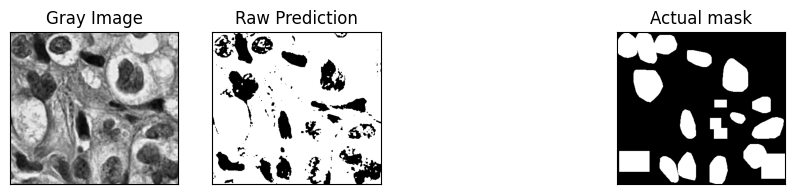

Confusion Matrix:
 [[94090  3348]
 [17020 22470]]
Full Test Accuracy: 0.8512502921243281


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Get random patient
id = np.random.choice(train_ids)
# Get random image for this patient
random_data = np.random.choice(get_all_image_names_for_id(id))
print(random_data)

img2 = get_rgb(random_data) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
csv_2 = get_csv(random_data)
labels_2 = label_array(img2,csv_2)

#Reshaping actual mask
labels_2 = np.array(labels_2).reshape(img2.shape, order='C')

X_test = img2.ravel().reshape(-1, 1)
y_test = labels_2.reshape(-1, 1)

test_classifier_plot(clf,X_test, y_test, img2)

In [ ]:
test_classifier(clf, X, y)

Confusion Matrix:
 [[17260166  2240904]
 [ 5553882  3863160]]
Full Test Accuracy: 0.7304531499151812


### 4.2.3 Validation images test

TCGA-E2-A150-DX1_id-5ea40996ddda5f8398980e6f_left-46434_top-65184_bottom-65453_right-46737


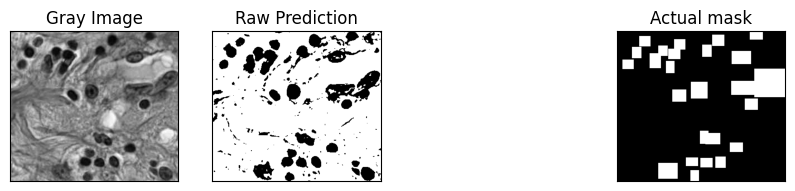

Confusion Matrix:
 [[93759  7789]
 [ 7881 14034]]
Full Test Accuracy: 0.8730793841069794


In [ ]:
valid_ids = get_patient_ids(False)

# Get random patient
id = np.random.choice(valid_ids)
# Get random image for this patient
random_data = np.random.choice(get_all_image_names_for_id(id))
print(random_data)

img2 = get_rgb(random_data) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
csv_2 = get_csv(random_data)
labels_2 = label_array(img2,csv_2)

#Reshaping actual mask
labels_2 = np.array(labels_2).reshape(img2.shape, order='C')

X_test = img2.ravel().reshape(-1, 1)
y_test = labels_2.reshape(-1, 1)

test_classifier_plot(clf,X_test, y_test, img2)

In [ ]:
# Get 50 random test images
X_valid = []
y_valid = []

# For each patient in validation split, get 2 images
for id in valid_ids:
  valid_paths = get_all_image_names_for_id(id)
  for valid_path in valid_paths[:2]:
    img1 = get_rgb(valid_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    csv1 = get_csv(valid_path)
    labels1 = label_array(img1, csv1)
    X_valid.append(img1.ravel())
    y_valid.append(labels1)

X_valid = [int(x) for x in itertools.chain(*X_valid)]
y_valid = [int(x) for x in itertools.chain(*y_valid)]
#Train random forest classifer on 100 image
X_valid = np.array(X_valid).reshape(-1, 1)
y_valid = np.array(y_valid).reshape(-1, 1)

In [ ]:
test_classifier(clf, X_valid, y_valid)

Confusion Matrix:
 [[4990060  889174]
 [1776263 1320277]]
Full Test Accuracy: 0.7030409856576157


### 4.2.4 Compare supervised and unsupervised methods

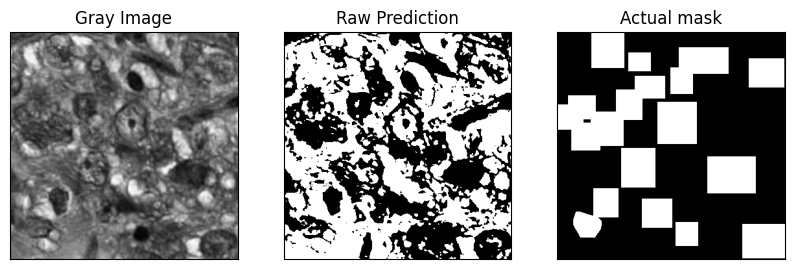

Confusion Matrix:
 [[51161 30463]
 [17610 24318]]
Test Accuracy: 0.6109087671587672


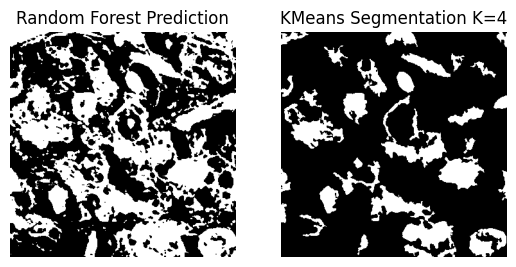

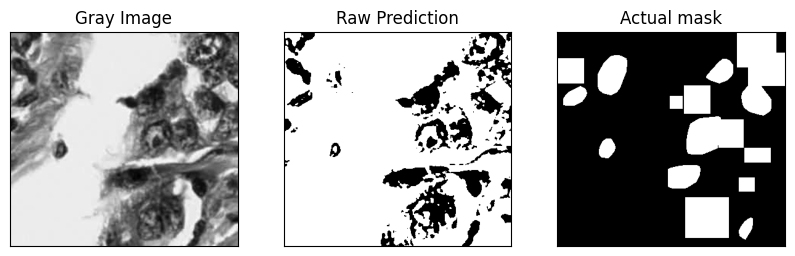

Confusion Matrix:
 [[91949  6667]
 [14966 15178]]
Test Accuracy: 0.8319897483690587


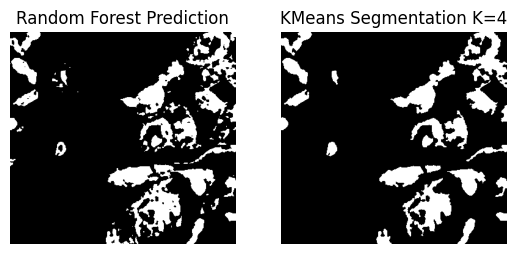

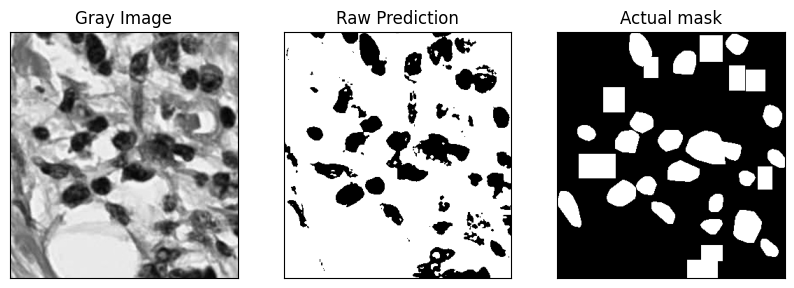

Confusion Matrix:
 [[83456  4852]
 [ 9639 16805]]
Test Accuracy: 0.8737189765755716


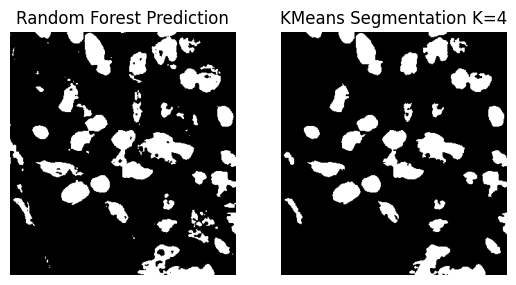

Average KMeans         DICE: 0.7853750231366606
Average Random Forrest DICE: 0.748129611840387


In [ ]:
valid_ids = get_patient_ids(False)
random_images = set()

for i in range(3):
  # Get random patient
  id = np.random.choice(valid_ids)
  # Get random image for this patient
  random_images.add(np.random.choice(get_all_image_names_for_id(id)))

random_images = list(random_images)
kmeans_dice = []
rf_dice = []

for img_path in random_images:
  img2_rgb = get_rgb(img_path) 
  img2 = cv2.cvtColor(img2_rgb, cv2.COLOR_BGR2GRAY)
  csv_2 = get_csv(img_path)
  img2_mask = get_mask(img_path)
  img2_mask = cv2.cvtColor(img2_mask, cv2.COLOR_BGR2GRAY)

  # Get Random Forrest Prediction
  labels_2 = label_array(img2,csv_2)
  labels_2 = np.array(labels_2).reshape(img2.shape, order='C')
  X_test = img2.ravel().reshape(-1, 1)
  y_test = labels_2.reshape(-1, 1)
  rf_pred, _ = test_classifier_plot(clf,X_test, y_test, img2)
  
  # Invert white and black
  inverted_img = cv2.bitwise_not(rf_pred)
  dice = cmpt_dice(img2_mask, inverted_img)
  rf_dice.append(dice)

  # Get KMeans Segmentation Prediction
  K = 4
  iterations = 10
  show = []
  res = kmeans(img2_rgb, K, iterations, show=show)
  prediction, shapes = calc_mask(img2_rgb, res)
  dice = cmpt_dice(img2_mask, prediction)
  kmeans_dice.append(dice)

  fig, axs = plt.subplots(1, 2)
  # display the images on the axis objects
  axs[0].imshow(inverted_img, cmap='gray')
  axs[0].set_title('Random Forest Prediction')
  axs[1].imshow(prediction, cmap='gray')
  axs[1].set_title('KMeans Segmentation K={}'.format(K))
  axs[1].axis("off"), axs[0].axis("off")
  plt.show()

print("Average KMeans         DICE: {}".format(np.average(kmeans_dice)))
print("Average Random Forrest DICE: {}".format(np.average(rf_dice)))

Based on DICE coefficients comparison and visual comparison, the KMeans unsupervised segmentation method seems to perform better.

### 4.2.5

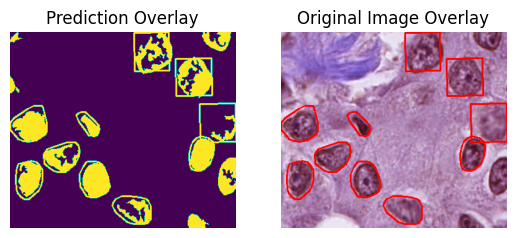

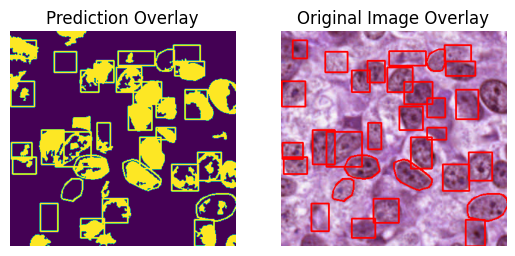

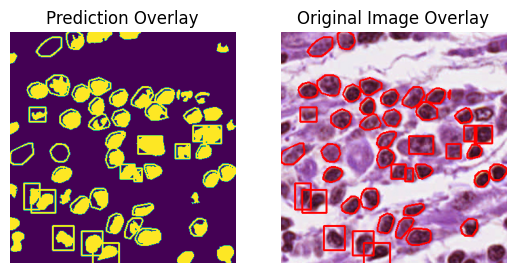

In [ ]:
for img_path in random_images:
  img2_rgb = get_rgb(img_path) 
  img2 = cv2.cvtColor(img2_rgb, cv2.COLOR_BGR2GRAY)
  csv_2 = get_csv(img_path)
  img2_mask = get_mask(img_path)
  img2_mask = cv2.cvtColor(img2_mask, cv2.COLOR_BGR2GRAY)

  # Get KMeans Segmentation Prediction
  K = 4
  iterations = 10
  show = []
  res = kmeans(img2_rgb, K, iterations, show=show)
  prediction, shapes = calc_mask(img2_rgb, res)
  dice = cmpt_dice(img2_mask, prediction)
  kmeans_dice.append(dice)

  csv_file = os.path.join(csv_2)
  prediction_overlay = overlay_image(prediction, csv_file)
  img1_overlay = overlay_image(img2_rgb, csv_file)

  # plt.figure(figsize=(5,5))
  fig, axs = plt.subplots(1, 2)

  # display the images on the axis objects
  axs[0].imshow(prediction_overlay)
  axs[1].imshow(img1_overlay)
  # set the titles for the subplots
  axs[0].set_title('Prediction Overlay')
  axs[1].set_title('Original Image Overlay')
  axs[1].axis("off"), axs[0].axis("off")
  plt.show()


Based on the images above, the nuclei group of larger, darker and not-overlapping nuclei can be segmented easily. 

### 4.2.6

The result in the previous question makes sense because: larger nuclei means that there are more pixels that can be grouped together and contoured by the segmentation. In addtion, darker nuclei are more distinct from the rest of the image (background) so it can be segmented easily. Finaly, nuclei that do not overlap with other nuclei are easier to segment because the contours are easier to detect.

# 5 Detecting and Counting Tumors

## Initialization (2)

In [ ]:


import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import sqrt, floor
import torch
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn import mixture
import os
import pandas as pd
from skimage.feature import blob_dog
import csv

from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
import glob
import time
import math
from collections import Counter


from sklearn.mixture import GaussianMixture
from skimage import io, segmentation, color
from sklearn.metrics import f1_score

# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline

from skimage.metrics import peak_signal_noise_ratio
import warnings
warnings.filterwarnings("ignore")

cuda:0


In [ ]:
## Useful methods 

def read_img(folder, img, gray=True, resize_img=False):   #used to read images 
  img_path = os.path.join(folder, img)
  image_input = cv2.imread(img_path)
  if gray:
    image_input = cv2.cvtColor(image_input, cv2.COLOR_RGB2GRAY)
  if resize_img:
    image_input = cv2.resize(image_input, (330, 370), interpolation=cv2.INTER_AREA)
  return image_input



def get_denoised_img(img, mask): #used to denoise images 
    product = img * mask
    for i in range(product.shape[0]):
      for j in range(product.shape[1]):
        if (mask[i, j] == 30):
          product[i, j] = 0
    return product


def get_extreme_values(path): 
  data_frame = pd.read_csv(path)
  xmins = data_frame["xmin"].values
  xmaxs = data_frame["xmax"].values
  ymins = data_frame["ymin"].values
  ymaxs = data_frame["ymax"].values
  raw_classifications = data_frame["raw_classification"].values

  return xmins, xmaxs, ymins, ymaxs, raw_classifications

## 5.1 Preparing the data

### 5.1.1 - 5.1.3

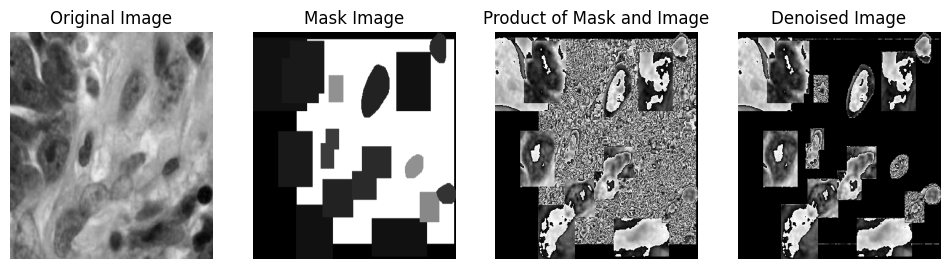

In [ ]:
chosen_file = 'TCGA-OL-A6VO-DX1_id-5ea4099fddda5f839898232e_left-89881_top-191292_bottom-191576_right-90211.png'
mask_path = os.path.join(path, 'mask') #mask path
rgb_path = os.path.join(path, 'rgb') #rgb path 


input_img = read_img(rgb_path, chosen_file, resize_img=True) #input image
mask_img = read_img(mask_path, chosen_file, resize_img=True)#mask image 
product_img = input_img * mask_img #product of input and mask image
denoised_img = get_denoised_img(input_img, mask_img) #denoised product image 

plt.figure(figsize=(12, 12))

plt.subplot(141)
plt.imshow(input_img,cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(142)
plt.imshow(mask_img,cmap='gray')
plt.title('Mask Image')
plt.axis('off')

plt.subplot(143)
plt.imshow(product_img,cmap='gray')
plt.title('Product of Mask and Image')
plt.axis('off')

plt.subplot(144)
plt.imshow(denoised_img,cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.show()

### 5.1.4 - 5.1.6

In [ ]:
splits_path = os.path.join(path, 'splits')

train_subj_df = pd.read_csv(splits_path + "/train_subjects.csv")
test_subj_df = pd.read_csv(splits_path + "/validate_subjects.csv")

mask_train = []
gray_train = []

mask_test = []
gray_test = []

mask_name_train = []
mask_name_test = []

num_imgs = 0
num_imgs2 = 0 

for image_id in train_subj_df["patient_id"]:                        
  mask_file_list = glob.glob(mask_path + "/" + image_id + "*")
  for mask_img in mask_file_list:
    mask_name_train.append(mask_img)
    img = read_img("", mask_img)
    mask_train.append(img)
    img = read_img("", mask_img.replace("mask", "rgb"))
    gray_train.append(img)
    num_imgs += 1
    if num_imgs == 100:
      break
  if num_imgs == 100:
    break


for image_id in test_subj_df["patient_id"]:                      
  mask_file_list = glob.glob(mask_path + "/" + image_id + "*")
  for mask_img in mask_file_list:
    mask_name_test.append(mask_img)
    img = read_img("", mask_img)
    mask_test.append(img)
    img = read_img("", mask_img.replace("mask", "rgb"))
    gray_test.append(img)
    num_imgs2 += 1
    if num_imgs2 == 26:
      break
  if num_imgs2 == 26:
    break

    
NUM_IMGS = len(mask_train)
NUM_IMGS2 = len(mask_test)


Validation set classification report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2241
           1       0.77      0.64      0.70       728

    accuracy                           0.87      2969
   macro avg       0.83      0.79      0.81      2969
weighted avg       0.86      0.87      0.86      2969

Test set classification report:
              precision    recall  f1-score   support

           0       0.65      0.90      0.76       436
           1       0.69      0.32      0.44       307

    accuracy                           0.66       743
   macro avg       0.67      0.61      0.60       743
weighted avg       0.67      0.66      0.62       743



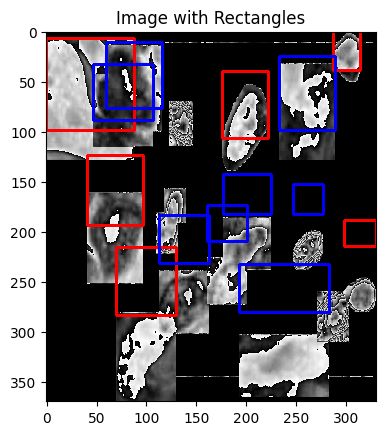

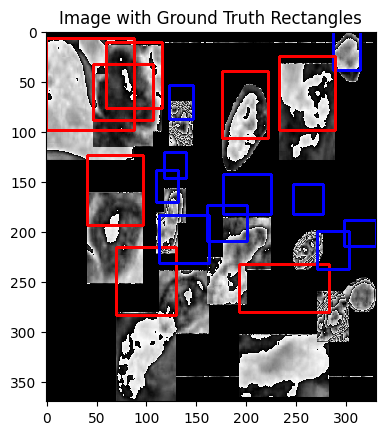

In [ ]:

from skimage import feature
from skimage.measure import regionprops
from sklearn.preprocessing import StandardScaler
from torchvision import models, transforms
import torch
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def extract_handcrafted_features(image, blob_coords):
    x_min, x_max, y_min, y_max = blob_coords
    blob = image[y_min:y_max, x_min:x_max]

    props = regionprops(blob)
    if len(props) == 0:  # Check if there are any connected components in the blob
        return None

    # Intensity features
    mean_intensity = np.mean(blob)
    std_intensity = np.std(blob)
    skewness = np.mean((blob - mean_intensity) ** 3) / std_intensity ** 3
    kurtosis = np.mean((blob - mean_intensity) ** 4) / std_intensity ** 4 - 3

    # Texture features (Local Binary Patterns)
    lbp = feature.local_binary_pattern(blob, 8, 1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(11), density=True)

    # Shape features
    props = regionprops(blob)
    area = props[0].area
    perimeter = props[0].perimeter
    compactness = 4 * np.pi * area / (perimeter ** 2)

    return np.concatenate(([mean_intensity, std_intensity, skewness, kurtosis], lbp_hist, [area, perimeter, compactness]))


all_X = []
all_Y = []
resized_masks = []
resized_masks2 = []

denoised_imgs = []
denoised_imgs2 = []

##for the training set 
for i in range(NUM_IMGS): 
    resized_mask = cv2.resize(gray_train[i], (mask_train[i].shape[1], mask_train[i].shape[0]))
    denoised_img = get_denoised_img(resized_mask, mask_train[i])
    
    resized_masks.append(resized_mask)
    denoised_imgs.append(denoised_img)

#for the testing set
for i in range(NUM_IMGS2):
    resized_mask = cv2.resize(gray_test[i], (mask_test[i].shape[1], mask_test[i].shape[0]))
    denoised_img = get_denoised_img(resized_mask, mask_test[i])
    
    resized_masks2.append(resized_mask)
    denoised_imgs2.append(denoised_img)


## 5.1.6 ##
# Get columns from CSV
csv_file_paths = [mask_img_name.replace("mask", "csv").replace("png", "csv") for mask_img_name in mask_name_train]
# for testing set
csv_file_paths2 = [mask_img_name.replace("mask", "csv").replace("png", "csv") for mask_img_name in mask_name_test]

# Extract features and labels for all blobs in each image
features_list = []
labels_list = []
for img, csv_file_path in zip(denoised_imgs, csv_file_paths):
    xmins, xmaxs, ymins, ymaxs, classifications = get_extreme_values(csv_file_path)
    for xmin, xmax, ymin, ymax, lbl in zip(xmins, xmaxs, ymins, ymaxs, classifications):
        coords = (xmin, xmax, ymin, ymax)
        features = extract_handcrafted_features(img, coords)
        if features is not None:  # Only append features and labels if the blob is not empty
            features_list.append(features)
            labels_list.append(1 if lbl == "tumor" else 0)

features_list2 = []
labels_list2 = []
labels_list3 = []
for img, csv_file_path in zip(denoised_imgs2, csv_file_paths2):
    xmins, xmaxs, ymins, ymaxs, classifications = get_extreme_values(csv_file_path)
    for xmin, xmax, ymin, ymax, lbl in zip(xmins, xmaxs, ymins, ymaxs, classifications):
        coords = (xmin, xmax, ymin, ymax)
        features = extract_handcrafted_features(img, coords)
        if features is not None:  # Only append features and labels if the blob is not empty
            features_list2.append(features)
            labels_list2.append(1 if lbl == "tumor" else 0)
            labels_list3.append(lbl)




# Create a DataFrame with extracted features and labels
data = pd.DataFrame(features_list)
data['label'] = labels_list

data2 = pd.DataFrame(features_list2)
data2['label'] = labels_list2

# Preprocess the features
scaler = StandardScaler()

# Replace infinity values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the mean of the corresponding feature
data.fillna(data.mean(), inplace=True)
data2.fillna(data2.mean(), inplace=True)

data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
data2.iloc[:, :-1] = scaler.fit_transform(data2.iloc[:, :-1])

X_train, y_train = data.iloc[:, :-1], data['label']
X_test, y_test = data2.iloc[:, :-1], data2['label']

# Train the classifier
clf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = clf.predict(X_train)
print("Validation set classification report:")
print(classification_report(y_train, y_val_pred))

# Test the model on the test set
y_test_pred = clf.predict(X_test)
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

# Path to the masks folder.
mask_f_path = os.path.join(path, 'mask')
# Path to the masks folder.
rgb_f_path = os.path.join(path, 'rgb')
# Define image name of desired subject.
subject_file = 'TCGA-OL-A6VO-DX1_id-5ea4099fddda5f839898232e_left-89881_top-191292_bottom-191576_right-90211.png'
subject_file_csv = '/TCGA-OL-A6VO-DX1_id-5ea4099fddda5f839898232e_left-89881_top-191292_bottom-191576_right-90211.csv'


input_img = read_img(rgb_f_path, subject_file, resize_img=True)
mask_img = read_img(mask_f_path, subject_file, resize_img=True)
denoised_img = get_denoised_img(input_img, mask_img)



new_csv_path =  mask_f_path.replace("mask", "csv").replace("png", "csv")
new_csv_path = new_csv_path + subject_file_csv

xmins, xmaxs, ymins, ymaxs, _ = get_extreme_values(new_csv_path)

new_features_list = []
for xmin, xmax, ymin, ymax in zip(xmins, xmaxs, ymins, ymaxs):
    coords = (xmin, xmax, ymin, ymax)
    new_features = extract_handcrafted_features(denoised_img, coords)
    if new_features is not None:
        new_features_list.append(new_features)


new_data = pd.DataFrame(new_features_list)

# Replace infinity values with NaN
new_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the mean of the corresponding feature
new_data.fillna(data.mean(), inplace=True)

new_data_scaled = scaler.transform(new_data)

new_predictions = clf.predict(new_data_scaled)

img_with_rectangles = cv2.cvtColor(denoised_img.copy(), cv2.COLOR_GRAY2BGR)

tumor_color = (0, 0, 255)  # Red
non_tumor_color = (255, 0, 0)  # Blue

for (xmin, xmax, ymin, ymax), prediction in zip(zip(xmins, xmaxs, ymins, ymaxs), new_predictions):
    color = tumor_color if prediction == 1 else non_tumor_color
    cv2.rectangle(img_with_rectangles, (xmin, ymin), (xmax, ymax), color, 2)


plt.imshow(cv2.cvtColor(img_with_rectangles, cv2.COLOR_BGR2RGB))
plt.title('Image with Rectangles')
plt.show()

# Create a new copy of the image with colored rectangles
img_with_gt = cv2.cvtColor(denoised_img.copy(), cv2.COLOR_GRAY2BGR)

# Define the colors for ground truth rectangles
gt_tumor_color = (0, 255, 0)  # Green
gt_non_tumor_color = (255, 255, 0)  # Yellow

get_extreme_values
xmins, xmaxs, ymins, ymaxs, classifications = get_extreme_values(new_csv_path)

# Draw ground truth rectangles
for (xmin, xmax, ymin, ymax), classification in zip(zip(xmins, xmaxs, ymins, ymaxs), classifications):
    color = tumor_color if classification == 'tumor' else non_tumor_color
    cv2.rectangle(img_with_gt, (xmin, ymin), (xmax, ymax), color, 2)

# Display the image with ground truth rectangles
plt.imshow(cv2.cvtColor(img_with_gt, cv2.COLOR_BGR2RGB))
plt.title('Image with Ground Truth Rectangles')
plt.show()


## 5.2 Classification Framework

### 5.2.1

The performance metric of the detection model for both training and validation images can be found in the classification report above. We find that we obtain an accuracy of 87% for our validation set and 66% for our test test. In depth analysis of the results can be found in our report.

### 5.2.2

In [ ]:
def RMSE (actual, predidcted):
  rmse = np.sqrt(np.mean((predidcted - actual) ** 2))
  return rmse

rmse = RMSE(y_train,y_val_pred)

print("Root Mean Squared Error:", rmse)




Root Mean Squared Error: 0.3661309455867779


### 5.2.4

In [ ]:
unique_elements, counts = np.unique(labels_list3, return_counts=True)

unique_elements2 = np.zeros_like(counts)


for label, y_label in zip(labels_list3, y_val_pred):
    if y_label == 1 and label != 'tumor':
      indice = np.where(unique_elements == label)
      unique_elements2[indice] = unique_elements2[indice] + 1

print(unique_elements2)

for count, mistake, element in zip(counts, unique_elements2, unique_elements):
    fail_rate = float(mistake) / count * 100  # Cast mistake to float
    print(f"For Cell Type: {element}, Fail Rate: {fail_rate}%")


[ 1  0  0 31 59  0  0 15  0 30  4]
For Cell Type: apoptotic_body, Fail Rate: 50.0%
For Cell Type: ductal_epithelium, Fail Rate: 0.0%
For Cell Type: eosinophil, Fail Rate: 0.0%
For Cell Type: fibroblast, Fail Rate: 30.392156862745097%
For Cell Type: lymphocyte, Fail Rate: 36.19631901840491%
For Cell Type: macrophage, Fail Rate: 0.0%
For Cell Type: mitotic_figure, Fail Rate: 0.0%
For Cell Type: plasma_cell, Fail Rate: 57.692307692307686%
For Cell Type: tumor, Fail Rate: 0.0%
For Cell Type: unlabeled, Fail Rate: 26.08695652173913%
For Cell Type: vascular_endothelium, Fail Rate: 66.66666666666666%


We find that ductal epithelium, eosinophil, macrophage, and mitotic_figure are the easiest to segregate from tumors as they have a fail rate of 0%. This means that in no occasion were these structures incorrectly labeled as tumors.In depth analysis of results can be found in report. 

### 5.2.3

Validation set classification report:
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1720
           1       0.82      0.08      0.14       598

    accuracy                           0.76      2318
   macro avg       0.79      0.54      0.50      2318
weighted avg       0.77      0.76      0.67      2318

Test set classification report:
              precision    recall  f1-score   support

           0       0.60      0.98      0.75       262
           1       0.71      0.05      0.10       182

    accuracy                           0.60       444
   macro avg       0.66      0.52      0.42       444
weighted avg       0.65      0.60      0.48       444



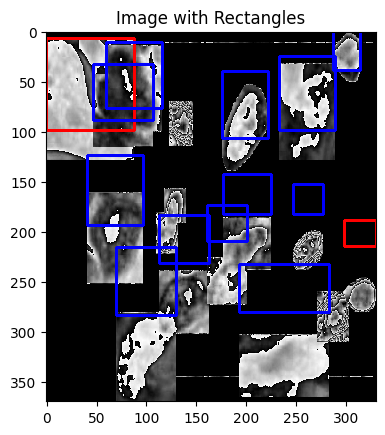

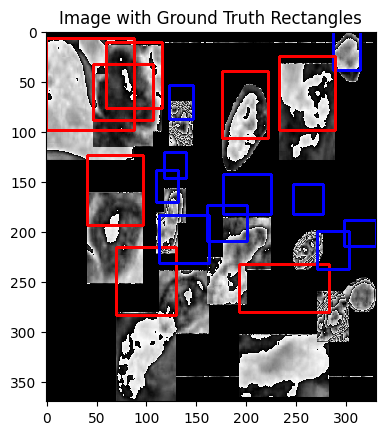

In [ ]:

from skimage import feature
from skimage.measure import regionprops
from sklearn.preprocessing import StandardScaler
from torchvision import models, transforms
import torch
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def extract_handcrafted_features(image, blob_coords):
    x_min, x_max, y_min, y_max = blob_coords
    blob = image[y_min:y_max, x_min:x_max]
    if blob.size == 0:
      return None

    props = regionprops(blob)
    if len(props) == 0:  # Check if there are any connected components in the blob
        return None

    # Intensity features
    mean_intensity = np.mean(blob)
    std_intensity = np.std(blob)
    skewness = np.mean((blob - mean_intensity) ** 3) / std_intensity ** 3
    kurtosis = np.mean((blob - mean_intensity) ** 4) / std_intensity ** 4 - 3

    # Texture features (Local Binary Patterns)
    lbp = feature.local_binary_pattern(blob, 8, 1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(11), density=True)

    # Shape features
    props = regionprops(blob)
    area = props[0].area
    perimeter = props[0].perimeter
    compactness = 4 * np.pi * area / (perimeter ** 2)

    return np.concatenate(([mean_intensity, std_intensity, skewness, kurtosis], lbp_hist, [area, perimeter, compactness]))


all_X = []
all_Y = []
resized_masks = []
resized_masks2 = []

denoised_imgs = []
denoised_imgs2 = []

##for the training set 
for i in range(NUM_IMGS): 
    resized_mask = cv2.resize(gray_train[i], (mask_train[i].shape[1], mask_train[i].shape[0]))
    resized_masks.append(resized_mask)
    denoised_imgs.append(denoised_img)

#for the testing set
for i in range(NUM_IMGS2):
    resized_mask = cv2.resize(gray_test[i], (mask_test[i].shape[1], mask_test[i].shape[0]))
    resized_masks2.append(resized_mask)
    denoised_imgs2.append(denoised_img)


## 5.1.6 ##
# Get columns from CSV
csv_file_paths = [mask_img_name.replace("mask", "csv").replace("png", "csv") for mask_img_name in mask_name_train]
# for testing set
csv_file_paths2 = [mask_img_name.replace("mask", "csv").replace("png", "csv") for mask_img_name in mask_name_test]

# Extract features and labels for all blobs in each image
features_list = []
labels_list = []
for img, csv_file_path in zip(denoised_imgs, csv_file_paths):
    xmins, xmaxs, ymins, ymaxs, classifications = get_extreme_values(csv_file_path)
    for xmin, xmax, ymin, ymax, lbl in zip(xmins, xmaxs, ymins, ymaxs, classifications):
        coords = (xmin, xmax, ymin, ymax)
        features = extract_handcrafted_features(img, coords)
        if features is not None:  # Only append features and labels if the blob is not empty
            features_list.append(features)
            labels_list.append(1 if lbl == "tumor" else 0)

features_list2 = []
labels_list2 = []
for img, csv_file_path in zip(denoised_imgs2, csv_file_paths2):
    xmins, xmaxs, ymins, ymaxs, classifications = get_extreme_values(csv_file_path)
    for xmin, xmax, ymin, ymax, lbl in zip(xmins, xmaxs, ymins, ymaxs, classifications):
        coords = (xmin, xmax, ymin, ymax)
        features = extract_handcrafted_features(img, coords)
        if features is not None:  # Only append features and labels if the blob is not empty
            features_list2.append(features)
            labels_list2.append(1 if lbl == "tumor" else 0)




# Create a DataFrame with extracted features and labels
data = pd.DataFrame(features_list)
data['label'] = labels_list

data2 = pd.DataFrame(features_list2)
data2['label'] = labels_list2

# Preprocess the features
scaler = StandardScaler()

# Replace infinity values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the mean of the corresponding feature
data.fillna(data.mean(), inplace=True)
data2.fillna(data2.mean(), inplace=True)

data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
data2.iloc[:, :-1] = scaler.fit_transform(data2.iloc[:, :-1])

X_train, y_train = data.iloc[:, :-1], data['label']
X_test, y_test = data2.iloc[:, :-1], data2['label']

# Train the classifier
clf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = clf.predict(X_train)
print("Validation set classification report:")
print(classification_report(y_train, y_val_pred))

# Test the model on the test set
y_test_pred = clf.predict(X_test)
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

# Path to the masks folder.
mask_f_path = os.path.join(path, 'mask')
# Path to the masks folder.
rgb_f_path = os.path.join(path, 'rgb')
# Define image name of desired subject.
subject_file = 'TCGA-OL-A6VO-DX1_id-5ea4099fddda5f839898232e_left-89881_top-191292_bottom-191576_right-90211.png'
subject_file_csv = '/TCGA-OL-A6VO-DX1_id-5ea4099fddda5f839898232e_left-89881_top-191292_bottom-191576_right-90211.csv'

input_img = read_img(rgb_f_path, subject_file, resize_img=True)
mask_img = read_img(mask_f_path, subject_file, resize_img=True)
denoised_img = get_denoised_img(input_img, mask_img)



new_csv_path =  mask_f_path.replace("mask", "csv").replace("png", "csv")
new_csv_path = new_csv_path + subject_file_csv

xmins, xmaxs, ymins, ymaxs, _ = get_extreme_values(new_csv_path)

new_features_list = []
for xmin, xmax, ymin, ymax in zip(xmins, xmaxs, ymins, ymaxs):
    coords = (xmin, xmax, ymin, ymax)
    new_features = extract_handcrafted_features(denoised_img, coords)
    if new_features is not None:
        new_features_list.append(new_features)


new_data = pd.DataFrame(new_features_list)

# Replace infinity values with NaN
new_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the mean of the corresponding feature
new_data.fillna(data.mean(), inplace=True)

new_data_scaled = scaler.transform(new_data)

new_predictions = clf.predict(new_data_scaled)

img_with_rectangles = cv2.cvtColor(denoised_img.copy(), cv2.COLOR_GRAY2BGR)

tumor_color = (0, 0, 255)  # Red
non_tumor_color = (255, 0, 0)  # Blue

for (xmin, xmax, ymin, ymax), prediction in zip(zip(xmins, xmaxs, ymins, ymaxs), new_predictions):
    color = tumor_color if prediction == 1 else non_tumor_color
    cv2.rectangle(img_with_rectangles, (xmin, ymin), (xmax, ymax), color, 2)


plt.imshow(cv2.cvtColor(img_with_rectangles, cv2.COLOR_BGR2RGB))
plt.title('Image with Rectangles')
plt.show()

# Create a new copy of the image with colored rectangles
img_with_gt = cv2.cvtColor(denoised_img.copy(), cv2.COLOR_GRAY2BGR)

# Define the colors for ground truth rectangles
gt_tumor_color = (0, 255, 0)  # Green
gt_non_tumor_color = (255, 255, 0)  # Yellow

get_extreme_values
xmins, xmaxs, ymins, ymaxs, classifications = get_extreme_values(new_csv_path)

# Draw ground truth rectangles
for (xmin, xmax, ymin, ymax), classification in zip(zip(xmins, xmaxs, ymins, ymaxs), classifications):
    color = tumor_color if classification == 'tumor' else non_tumor_color
    cv2.rectangle(img_with_gt, (xmin, ymin), (xmax, ymax), color, 2)

# Display the image with ground truth rectangles
plt.imshow(cv2.cvtColor(img_with_gt, cv2.COLOR_BGR2RGB))
plt.title('Image with Ground Truth Rectangles')
plt.show()


The performance metric of the detection model for both training and validation images can be found in the classification report above. We find that we obtain an accuracy of 76% for our validation set and 60% for our test test. These accuracy values are significantly lower than those found when we processed the images. In depth analysis of the results can be found in our report.